# Proyecto Final Bioestadística

### Grupo 02
* Martín Cortés Albarracín - 202313528
* Hassan Eisa Cavieles Eljadue - 
* Sara Ximena Arias - 202


## Importamos librerías

In [60]:
import pandas as pd
import numpy as np
from pathlib import Path
import pingouin as pg
from scipy import stats
import matplotlib.pyplot as plt
from __future__ import annotations   
from itertools import product  
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.multivariate.manova import MANOVA
from scipy.stats import bootstrap
from scipy.spatial import distance
from numpy.linalg import inv
from scipy.stats import chi2
from normalizato_utile import *

## Carga de datos

In [45]:
df=pd.read_csv("Datos_G2.csv")
print(df["LocationDesc"].unique())
print(len(df))
columns_interes = ["Data_Value","Age","MMSE","ADL","CholesterolLDL","FunctionalAssessment"]

['West' 'Northeast' 'Midwest' 'Idaho' 'Louisiana' 'Massachusetts'
 'Maryland' 'New Mexico' 'Ohio' 'Oregon' 'South Carolina' 'South'
 'Wisconsin' 'Tennessee' 'New Hampshire' 'Kansas' 'Utah' 'Rhode Island'
 'Michigan' 'Washington' 'Virginia' 'Arizona' 'Mississippi' 'Montana'
 'West Virginia' 'Missouri' 'Vermont' 'Pennsylvania' 'North Carolina'
 'New Jersey' 'Arkansas' 'Hawaii' 'Connecticut' 'Minnesota' 'Texas'
 'Nebraska' 'New York' 'Maine' 'Alaska' 'Georgia' 'Indiana' 'Kentucky'
 'North Dakota' 'Oklahoma' 'Wyoming' 'District of Columbia' 'Iowa'
 'Alabama' 'South Dakota' 'Illinois' 'Colorado' 'Nevada' 'California'
 'Delaware']
2149


#### Histogramas

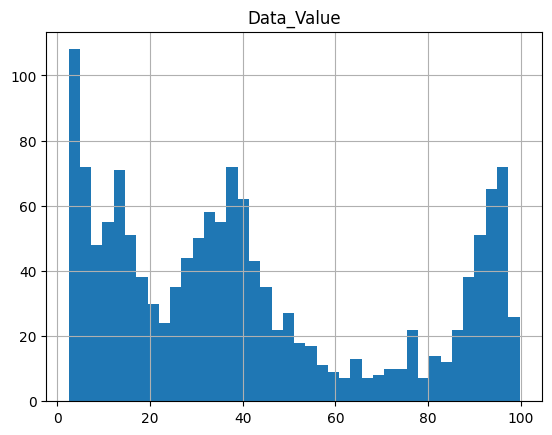

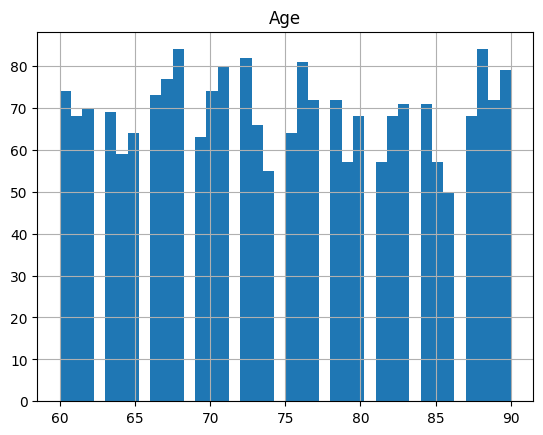

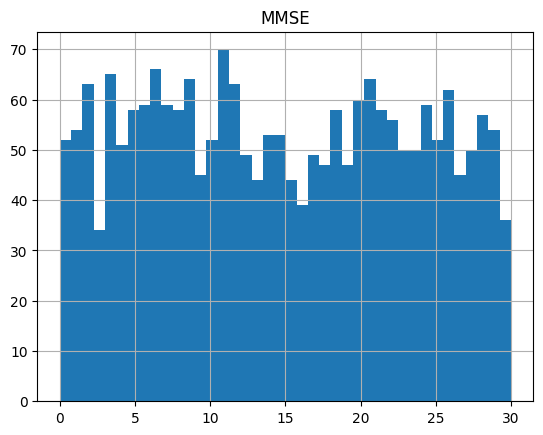

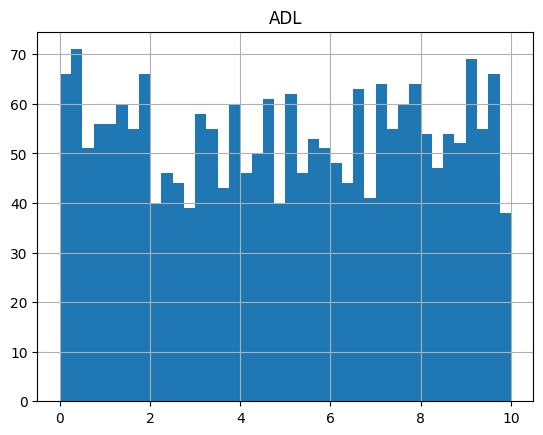

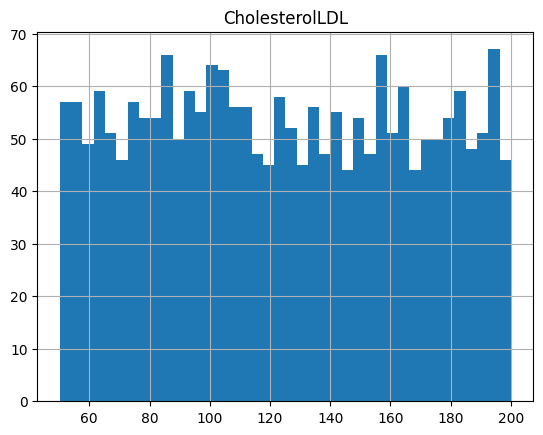

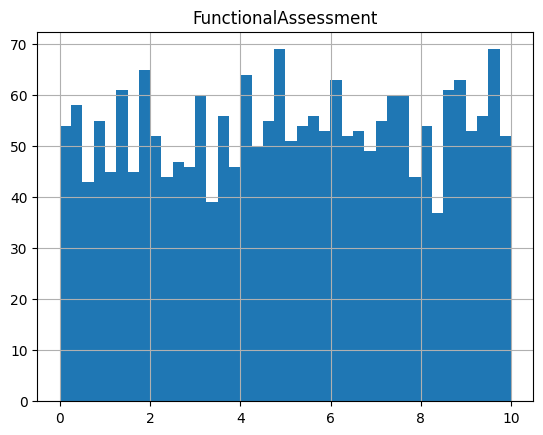

In [53]:
#[df[c].hist(bins=round(np.sqrt(len(df)))) for c in columns_interes]; plt.show()
for col in columns_interes:
  #df[col].hist(bins=round(np.sqrt(len(df)))); plt.title(col); plt.show()
  df[col].hist(bins=40); plt.title(col); plt.show()

#### Normalizado

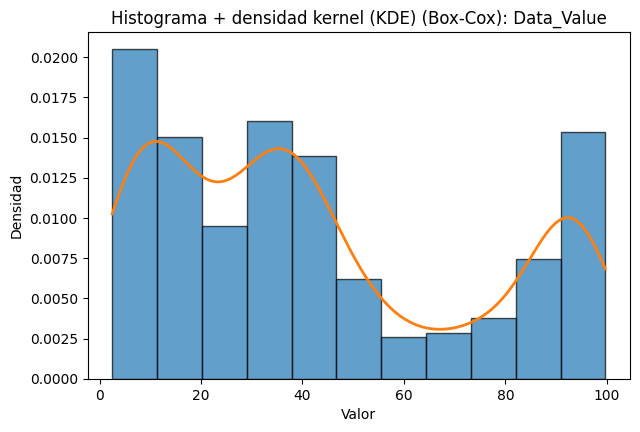

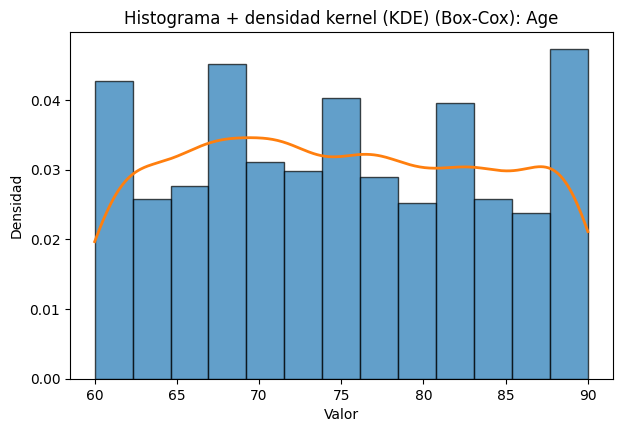

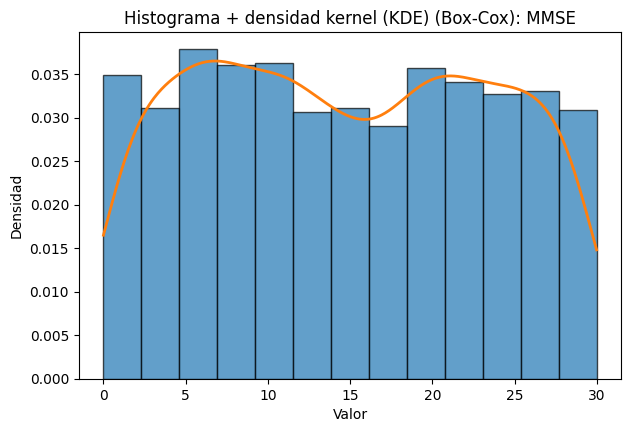

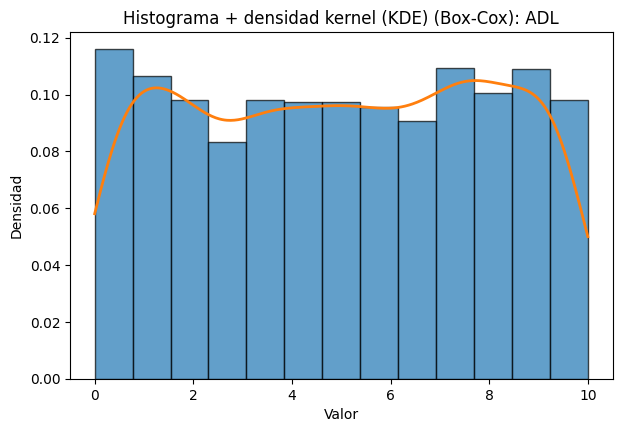

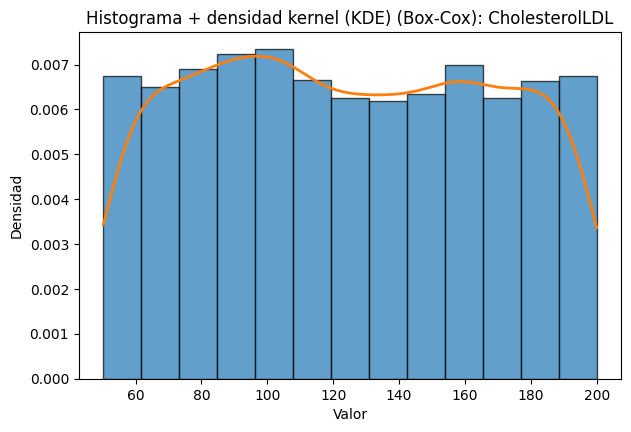

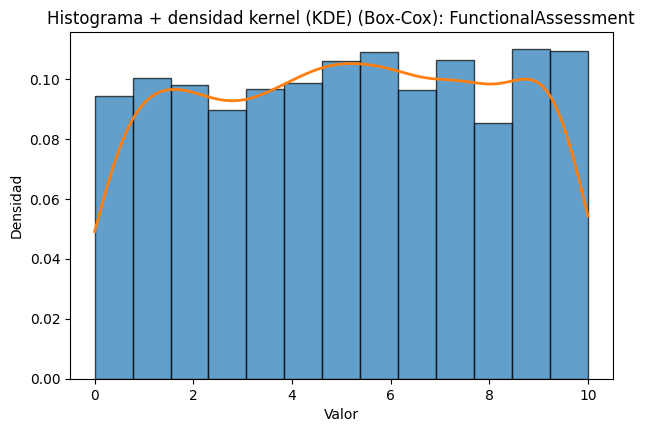

In [54]:
for col in columns_interes:
    columna = df[col].dropna()  # Remove NaNs
    plt.figure(figsize=(7,4.5))
    plt.hist(columna, bins="fd", density=True, alpha=0.7, edgecolor="black")
    kde = stats.gaussian_kde(columna)
    xs = np.linspace(columna.min(), columna.max(), 400)
    plt.plot(xs, kde(xs), linewidth=2)
    plt.title(f"Histograma + densidad kernel (KDE) (Box-Cox): {col}")
    plt.xlabel("Valor"); plt.ylabel("Densidad")
    plt.show()

In [ ]:

df_t, params = transform_df(df, columns=columns_interes, method="boxcox", standardize=True, na_action="ignore")

# 4) (Opcional) Reporte de normalidad
rep = normality_report(df, df_t, columns_interes)
rep.head()

# 5) Graficar una columna antes/después
plot_hist(df["col1"], "Before: col1")
plot_hist(df_t["col1"], "After (Box-Cox + z-score): col1")

ValueError: The `x` argument of `boxcox_normmax` must contain only positive, finite, real numbers.

#### Scatter Plots

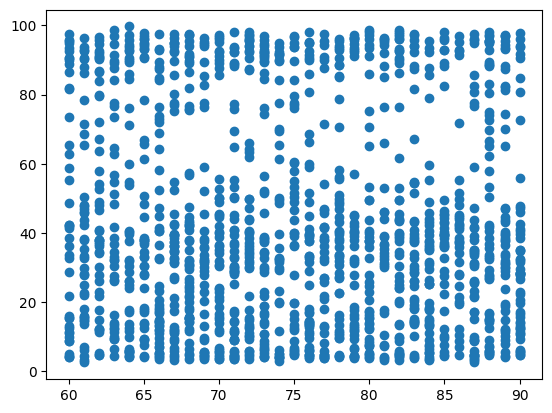

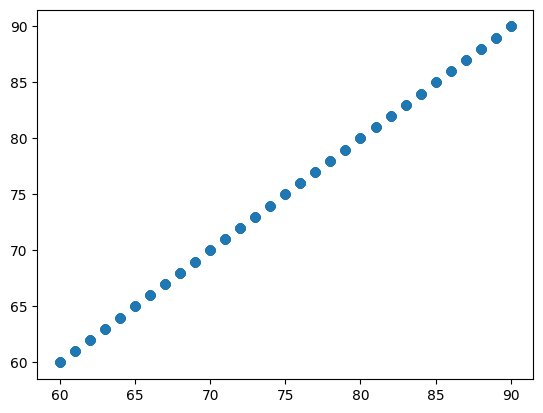

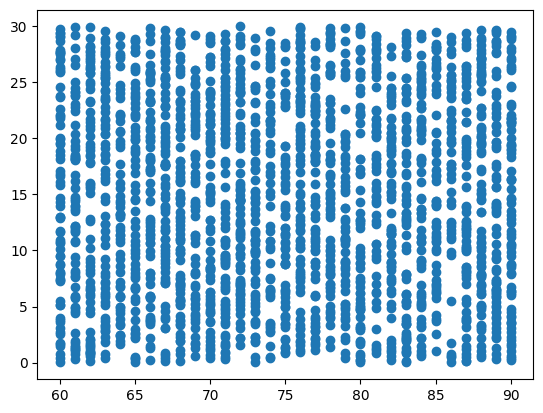

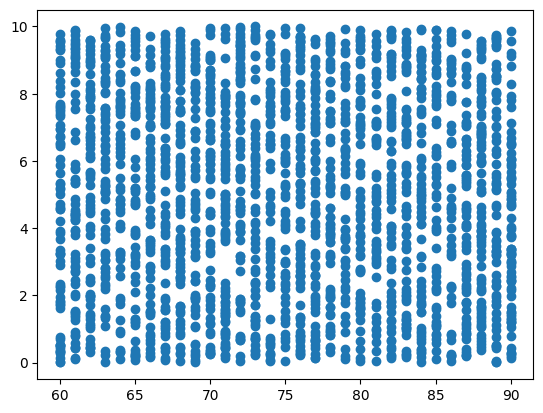

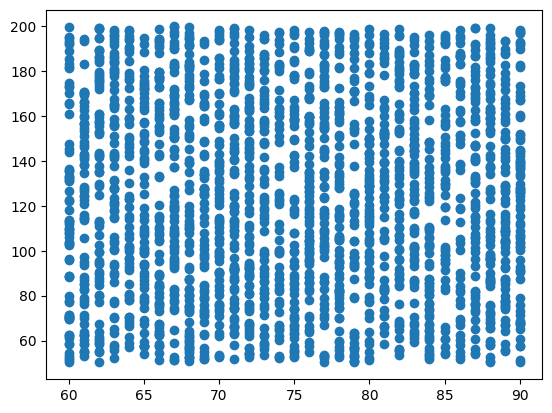

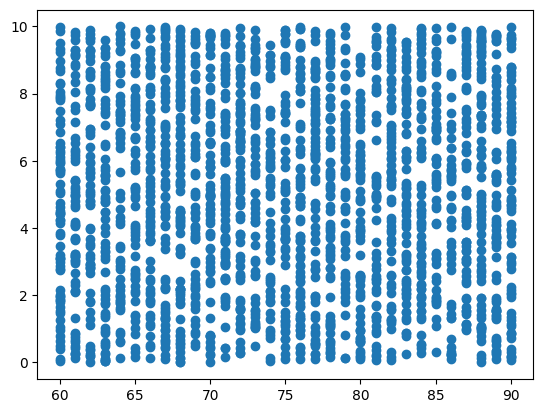

In [58]:
for c in columns_interes:
    num = df[["Age", c]].dropna()

    plt.scatter(num.iloc[:,0], num.iloc[:,1]); plt.show() 

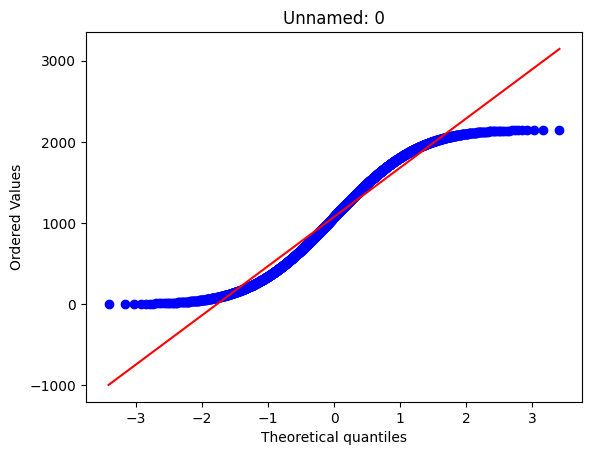

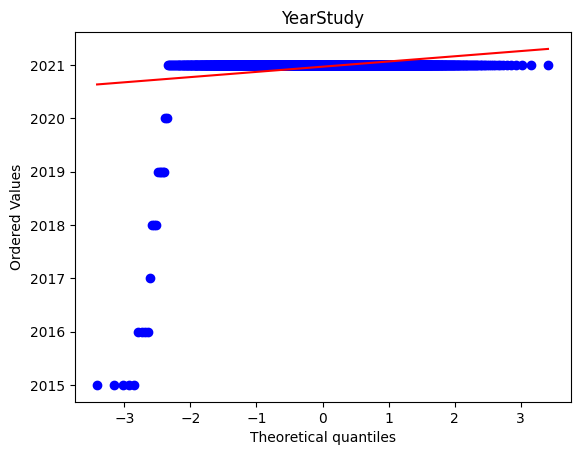

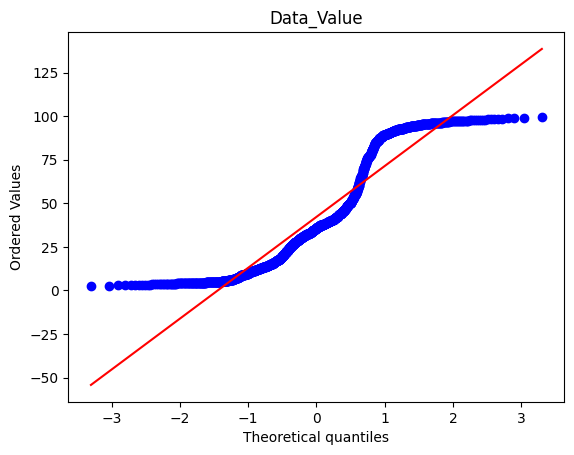

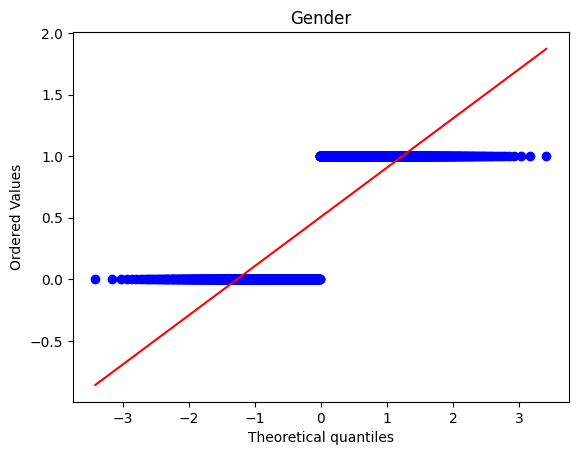

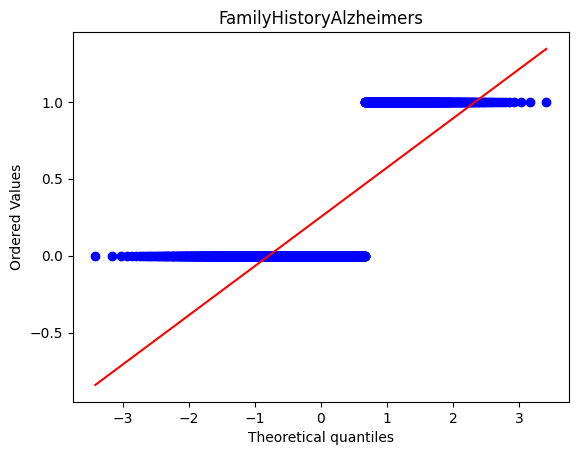

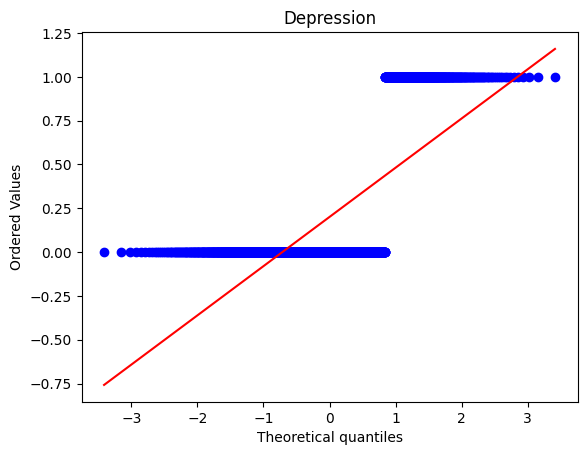

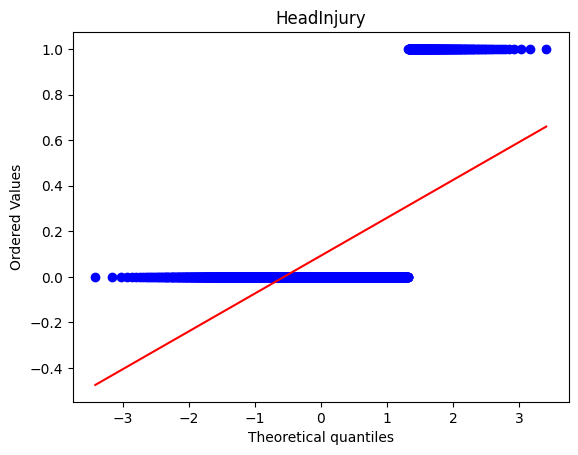

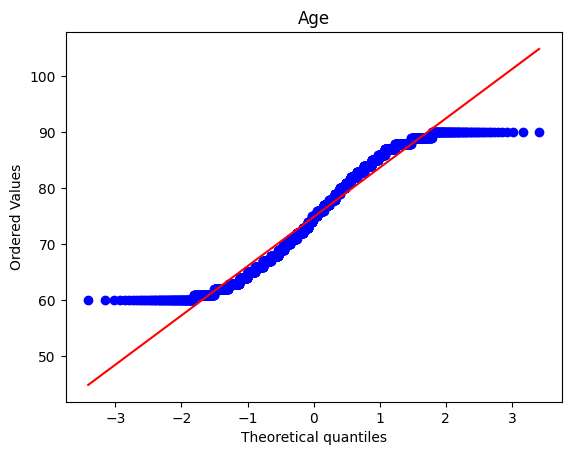

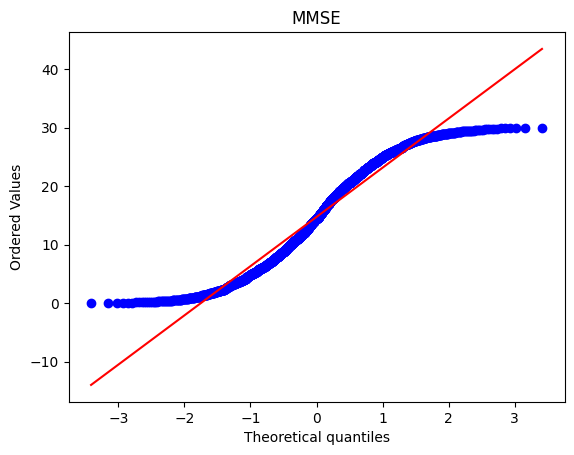

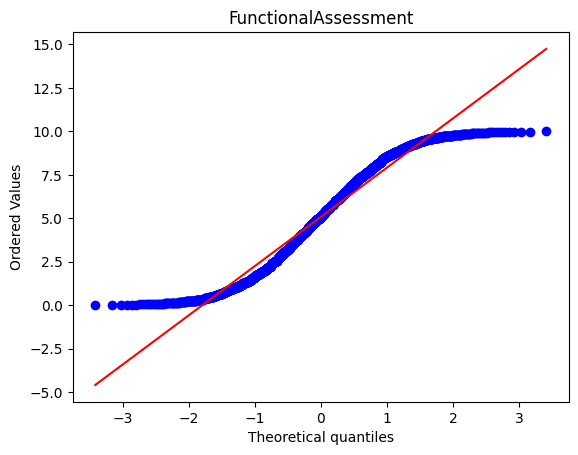

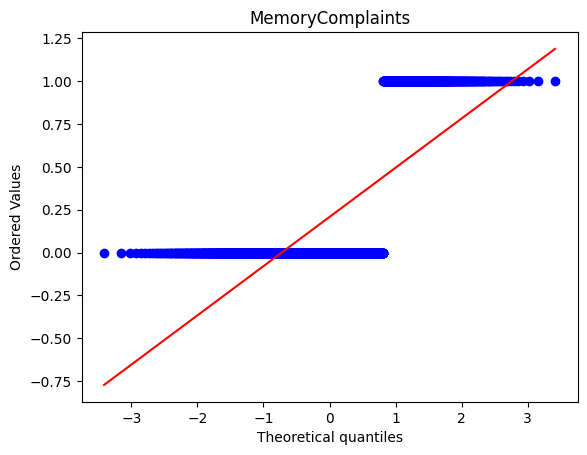

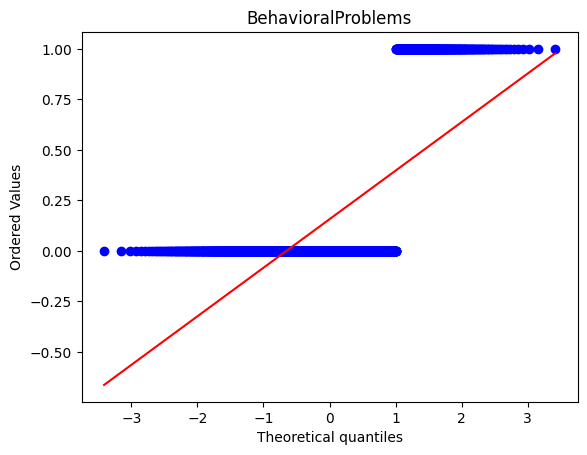

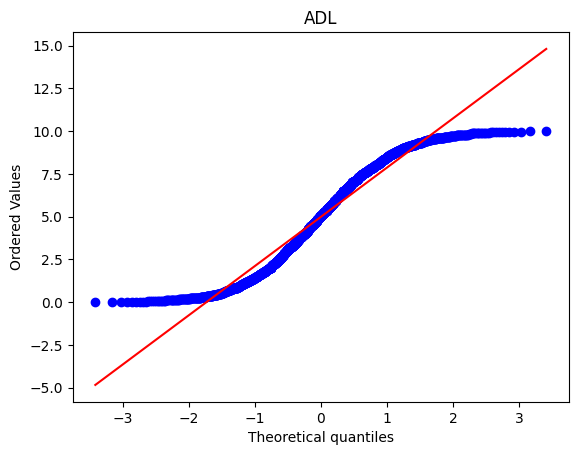

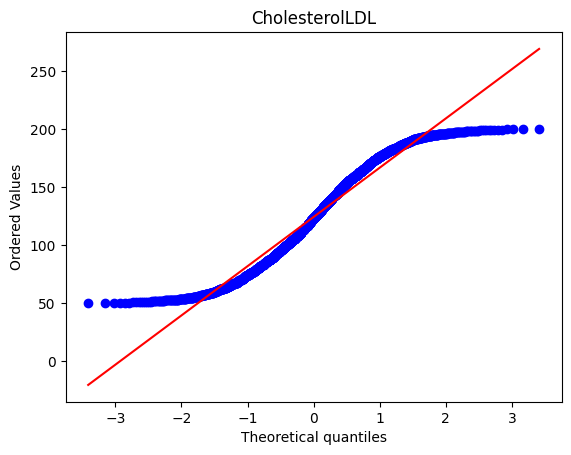

In [31]:
for col in df.select_dtypes(include="number").columns:
  stats.probplot(df[col].dropna(), dist="norm", plot=plt)
  plt.title(col); plt.show()

## MANOVA

In [61]:
formula = "Data_Value + CholesterolLDL  ~ C(Age) * C(MMSE)* C(LocationDesc)* C(Gender)"
manova = MANOVA.from_formula(formula, data=df)
mv_out = manova.mv_test()
print(mv_out) 

MemoryError: Unable to allocate 77.1 GiB for an array with shape (1439, 7194852) and data type float64